# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = None
temp_prec = ['../Tabular_data/precipitation_all.csv', '../Tabular_data/temperature_all 2.csv']
static = '../Tabular_data/dengue_tabular.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/variational_autoencoder_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, temp_prec=temp_prec, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

temperature  precipitation  Age0-4(%)  Age5-14(%)  Age15-29(%)  \
41001 201546     0.109192      -0.384028   0.706485    0.317881    -0.118812   
      201547    -0.038879      -0.701050   0.706485    0.317881    -0.118812   
      201548     0.320644      -0.582182   0.706485    0.317881    -0.118812   
      201549     0.490532      -0.884511   0.706485    0.317881    -0.118812   
      201550     0.369630      -0.361735   0.706485    0.317881    -0.118812   

              Age>30(%)  AfrocolombianPopulation(%)  IndianPopulation(%)  \
41001 201546  -0.320472                   -0.974267            -0.181818   
      201547  -0.320472                   -0.974267            -0.181818   
      201548  -0.320472                   -0.974267            -0.181818   
      201549  -0.320472                   -0.974267            -0.181818   
      201550  -0.320472                   -0.974267            -0.181818   

              PeoplewithDisabilities(%)  Peoplewhocannotreadorwrite(%)  ...  \
41001 201546                   0.492837                      -0.138643  ...   
      201547                   0.492837                      -0.138643  ...   
      201548                   0.492837                      -0.138643  ...   
      201549                   0.492837                      -0.138643  ...   
      201550                   0.492837                      -0.138643  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201546                    -0.38184                     0.90498   
      201547                    -0.38184                     0.90498   
      201548                    -0.38184                     0.90498   
      201549                    -0.38184                     0.90498   
      201550                    -0.38184                     0.90498   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201546                   -0.917415                   -0.851179   
      201547                   -0.917415                   -0.851179   
      201548                   -0.917415                   -0.851179   
      201549                   -0.917415                   -0.851179   
      201550                   -0.917415                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201546                     -0.7492                   -0.981855   
      201547                     -0.7492                   -0.981855   
      201548                     -0.7492                   -0.981855   
      201549                     -0.7492                   -0.981855   
      201550                     -0.7492                   -0.981855   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201546                -0.990366               -0.9891   -0.924272   
      201547                -0.990366               -0.9891   -0.924272   
      201548                -0.990366               -0.9891   -0.924272   
      201549                -0.990366               -0.9891   -0.924272   
      201550                -0.990366               -0.9891   -0.924272   

                Labels  
41001 201546 -0.861740  
      201547 -0.854589  
      201548 -0.856973  
      201549 -0.856973  
      201550 -0.823600  

[5 rows x 29 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

temperature  precipitation  Age0-4(%)  Age5-14(%)  Age15-29(%)  \
41001 201820    -0.094121      -0.653238   0.706485    0.317881    -0.118812   
      201821     0.023351      -0.600049   0.706485    0.317881    -0.118812   
      201822    -0.187106      -0.633564   0.706485    0.317881    -0.118812   
      201823    -0.214029      -0.884182   0.706485    0.317881    -0.118812   
      201824    -0.071286      -0.846962   0.706485    0.317881    -0.118812   

              Age>30(%)  AfrocolombianPopulation(%)  IndianPopulation(%)  \
41001 201820  -0.320472                   -0.974267            -0.181818   
      201821  -0.320472                   -0.974267            -0.181818   
      201822  -0.320472                   -0.974267            -0.181818   
      201823  -0.320472                   -0.974267            -0.181818   
      201824  -0.320472                   -0.974267            -0.181818   

              PeoplewithDisabilities(%)  Peoplewhocannotreadorwrite(%)  ...  \
41001 201820                   0.492837                      -0.138643  ...   
      201821                   0.492837                      -0.138643  ...   
      201822                   0.492837                      -0.138643  ...   
      201823                   0.492837                      -0.138643  ...   
      201824                   0.492837                      -0.138643  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201820                    -0.38184                     0.90498   
      201821                    -0.38184                     0.90498   
      201822                    -0.38184                     0.90498   
      201823                    -0.38184                     0.90498   
      201824                    -0.38184                     0.90498   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201820                   -0.917415                   -0.851179   
      201821                   -0.917415                   -0.851179   
      201822                   -0.917415                   -0.851179   
      201823                   -0.917415                   -0.851179   
      201824                   -0.917415                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201820                     -0.7492                   -0.981855   
      201821                     -0.7492                   -0.981855   
      201822                     -0.7492                   -0.981855   
      201823                     -0.7492                   -0.981855   
      201824                     -0.7492                   -0.981855   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201820                -0.990366               -0.9891   -0.924272   
      201821                -0.990366               -0.9891   -0.924272   
      201822                -0.990366               -0.9891   -0.924272   
      201823                -0.990366               -0.9891   -0.924272   
      201824                -0.990366               -0.9891   -0.924272   

                Labels  
41001 201820 -0.949940  
      201821 -0.961859  
      201822 -0.940405  
      201823 -0.961859  
      201824 -0.954708  

[5 rows x 29 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 85)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 85)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 84)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 84)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 84)
The test shape is (310, 84)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 28)
The test shape is (310, 3, 28)


# 2. Model

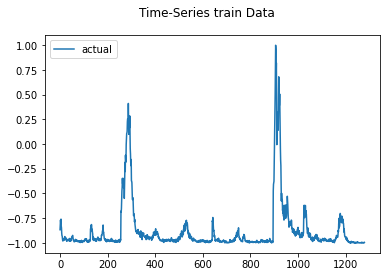

2023-03-08 15:53:46.458683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 15:53:46.458989: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 15:53:46.459051: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-08 15:53:46.459475: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 15:53:49.933425: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 41.359
Test RMSE: 51.728
Test sMAPE: 104.201
Test R Squared: -1.697
{'mae': 41.358975687526886, 'rmse': 51.72847962921128, 'smape': 104.20149643675194, 'r2': -1.697083316929724}


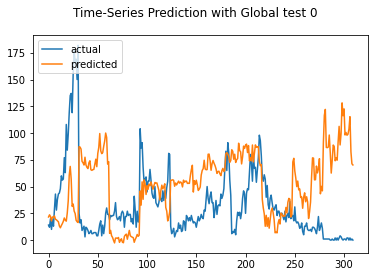

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 46.954
Test RMSE: 63.022
Test sMAPE: 154.870
Test R Squared: -3.003
{'mae': 46.953818896220575, 'rmse': 63.02230025727113, 'smape': 154.86963542263422, 'r2': -3.003348845226431}


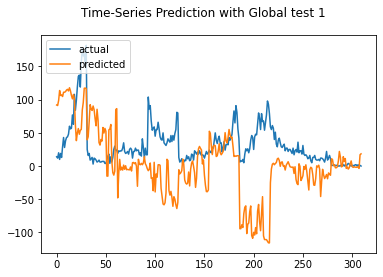

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 43.104
Test RMSE: 54.625
Test sMAPE: 109.665
Test R Squared: -2.008
{'mae': 43.103949885983624, 'rmse': 54.62512688679702, 'smape': 109.66546807750004, 'r2': -2.0075984481219393}


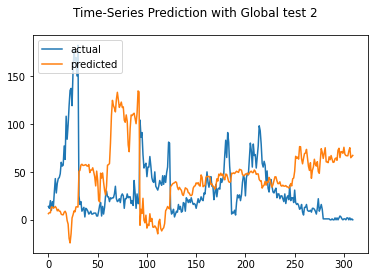

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 33.326
Test RMSE: 44.975
Test sMAPE: 101.460
Test R Squared: -1.039
{'mae': 33.32561490977964, 'rmse': 44.975220942916934, 'smape': 101.46007890445269, 'r2': -1.0388324891037168}


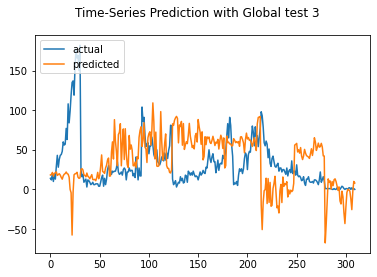

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 47.248
Test RMSE: 54.571
Test sMAPE: 114.150
Test R Squared: -2.002
{'mae': 47.24756145169658, 'rmse': 54.57079424196085, 'smape': 114.15010733310609, 'r2': -2.001618434172673}


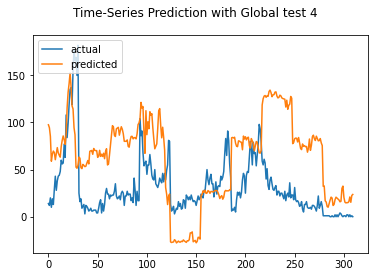

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 35.601
Test RMSE: 49.952
Test sMAPE: 89.668
Test R Squared: -1.515
{'mae': 35.60087263132295, 'rmse': 49.95173082468759, 'smape': 89.66829317026831, 'r2': -1.5149885761305177}


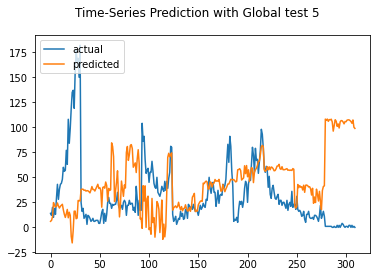

Test MAE: 51.115
Test RMSE: 56.711
Test sMAPE: 105.859
Test R Squared: -2.242
{'mae': 51.11480504274368, 'rmse': 56.71058985590315, 'smape': 105.85850768941734, 'r2': -2.2416286603324136}


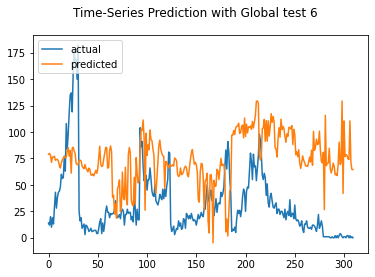

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 40.801
Test RMSE: 49.942
Test sMAPE: 119.769
Test R Squared: -1.514
{'mae': 40.80109804339947, 'rmse': 49.94153635007511, 'smape': 119.76893521850002, 'r2': -1.5139621303805502}


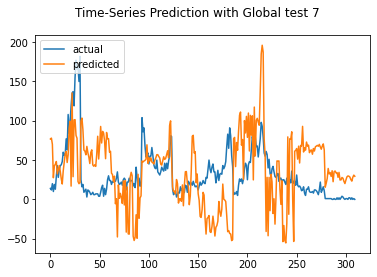

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 40.567
Test RMSE: 46.750
Test sMAPE: 101.116
Test R Squared: -1.203
{'mae': 40.566697483293474, 'rmse': 46.749548116002636, 'smape': 101.11590599973431, 'r2': -1.202874568251877}


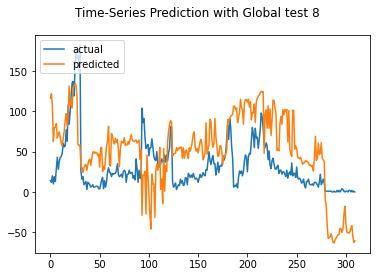

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 36.959
Test RMSE: 46.841
Test sMAPE: 110.978
Test R Squared: -1.212
{'mae': 36.9594508103786, 'rmse': 46.84134265771341, 'smape': 110.97785500671546, 'r2': -1.2115339198389008}


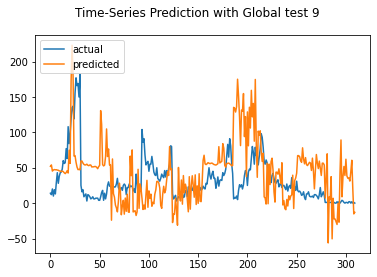

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 61.056
Test RMSE: 67.484
Test sMAPE: 120.283
Test R Squared: -3.590
{'mae': 61.05572979219498, 'rmse': 67.48376273240437, 'smape': 120.28342299370857, 'r2': -3.5902201396315885}


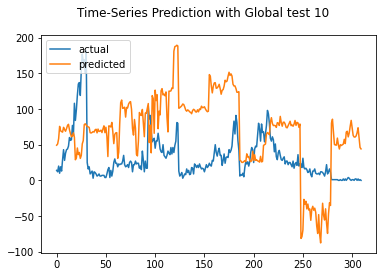

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 35.140
Test RMSE: 43.973
Test sMAPE: 92.522
Test R Squared: -0.949
{'mae': 35.140066020719466, 'rmse': 43.97255877512993, 'smape': 92.52206489702152, 'r2': -0.9489397373803958}


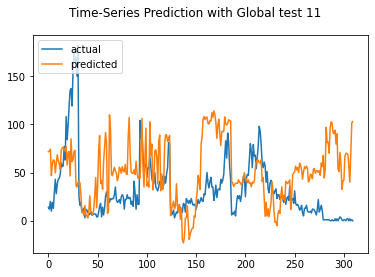

Test MAE: 36.681
Test RMSE: 44.940
Test sMAPE: 115.931
Test R Squared: -1.036
{'mae': 36.68061630716247, 'rmse': 44.94042354109113, 'smape': 115.93121274182805, 'r2': -1.035678813531005}


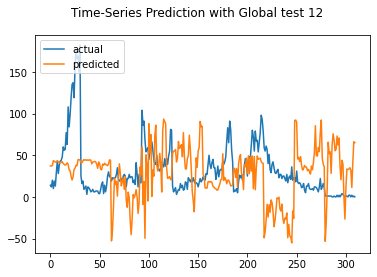

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 43.647
Test RMSE: 51.162
Test sMAPE: 101.038
Test R Squared: -1.638
{'mae': 43.64738225013979, 'rmse': 51.16154638723222, 'smape': 101.0377312808545, 'r2': -1.6382883522231615}


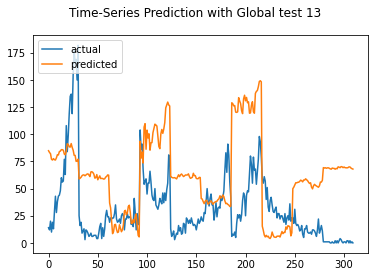

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.083
Test RMSE: 48.344
Test sMAPE: 98.687
Test R Squared: -1.356
{'mae': 41.082928662146294, 'rmse': 48.3439928850139, 'smape': 98.68740328790726, 'r2': -1.3556999305608537}


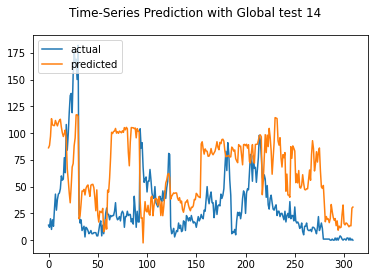

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 47.625
Test RMSE: 56.815
Test sMAPE: 110.295
Test R Squared: -2.254
{'mae': 47.625484230056884, 'rmse': 56.81466208400038, 'smape': 110.29519009483977, 'r2': -2.253537302930024}


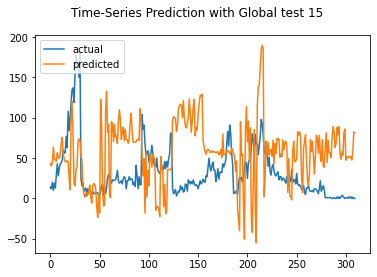

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 28.109
Test RMSE: 39.279
Test sMAPE: 98.359
Test R Squared: -0.555
{'mae': 28.109385146248727, 'rmse': 39.27867909341926, 'smape': 98.35907540065661, 'r2': -0.55506548902795}


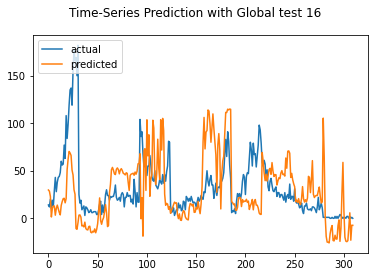

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 44.574
Test RMSE: 57.190
Test sMAPE: 117.890
Test R Squared: -2.297
{'mae': 44.57383151362019, 'rmse': 57.190429397854935, 'smape': 117.88987727405001, 'r2': -2.2967168599096093}


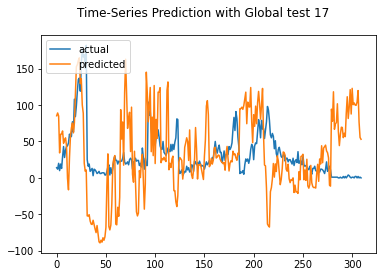

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 60.914
Test RMSE: 70.196
Test sMAPE: 109.215
Test R Squared: -3.967
{'mae': 60.91372014322589, 'rmse': 70.19647579969553, 'smape': 109.21507295981175, 'r2': -3.966672828624632}


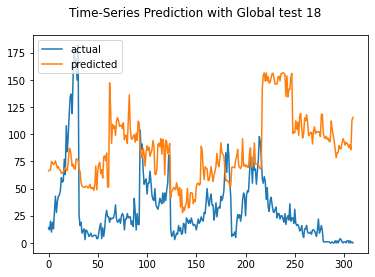

Test MAE: 63.821
Test RMSE: 74.507
Test sMAPE: 122.731
Test R Squared: -4.595
{'mae': 63.82090792156035, 'rmse': 74.50672004044607, 'smape': 122.7312894795407, 'r2': -4.595331539369532}


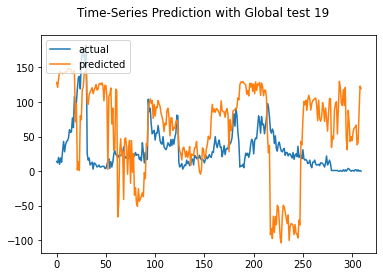

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.204
Test RMSE: 33.968
Test sMAPE: 97.802
Test R Squared: -0.163
{'mae': 25.203542901431362, 'rmse': 33.967657610950134, 'smape': 97.80176588182887, 'r2': -0.16296362977522327}


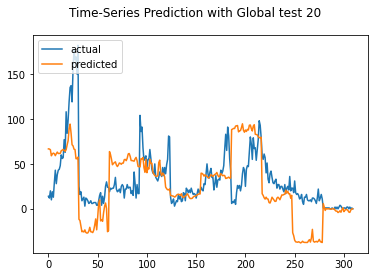

Test MAE: 64.591
Test RMSE: 74.382
Test sMAPE: 112.044
Test R Squared: -4.577
{'mae': 64.5912041418014, 'rmse': 74.38229079870176, 'smape': 112.04445223853756, 'r2': -4.576658284120108}


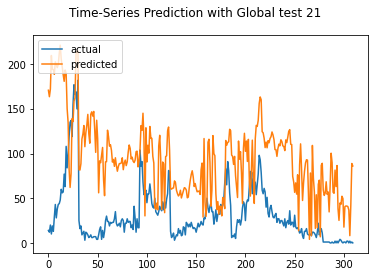

Test MAE: 73.373
Test RMSE: 83.697
Test sMAPE: 149.980
Test R Squared: -6.061
{'mae': 73.37289709948725, 'rmse': 83.69681131849285, 'smape': 149.97982524274786, 'r2': -6.060781295040185}


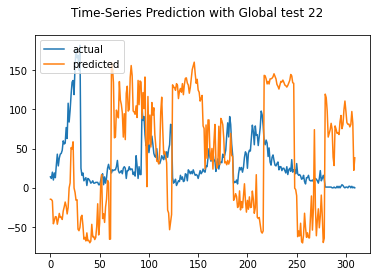

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 48.894
Test RMSE: 58.750
Test sMAPE: 144.939
Test R Squared: -2.479
{'mae': 48.89374987636843, 'rmse': 58.75024838223681, 'smape': 144.93938316398172, 'r2': -2.478999357760932}


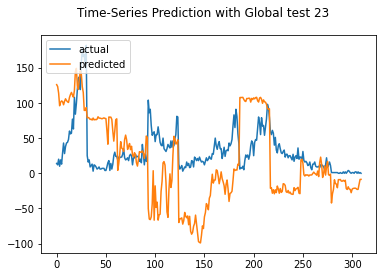

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 40.539
Test RMSE: 46.826
Test sMAPE: 102.646
Test R Squared: -1.210
{'mae': 40.53854238506286, 'rmse': 46.82602554268813, 'smape': 102.64644182945354, 'r2': -1.2100878135122652}


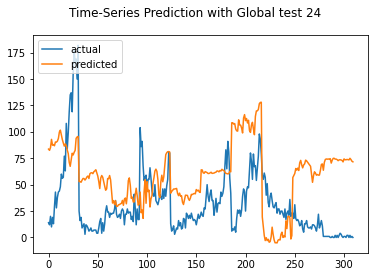

Test MAE: 48.826
Test RMSE: 58.980
Test sMAPE: 101.669
Test R Squared: -2.506
{'mae': 48.82551199659225, 'rmse': 58.9799728090701, 'smape': 101.66850063486216, 'r2': -2.5062596226193454}


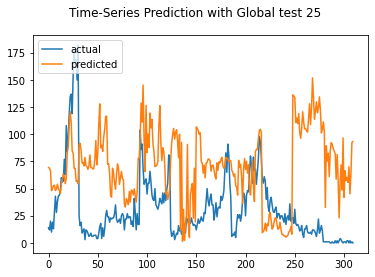

Test MAE: 54.659
Test RMSE: 65.539
Test sMAPE: 121.285
Test R Squared: -3.329
{'mae': 54.65946761158205, 'rmse': 65.53857353260497, 'smape': 121.28478566485343, 'r2': -3.3294118715765064}


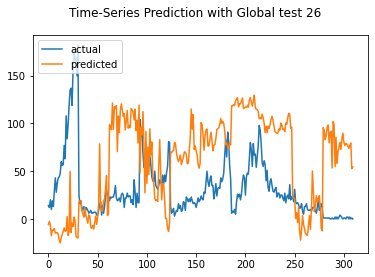

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 50.408
Test RMSE: 68.012
Test sMAPE: 102.517
Test R Squared: -3.662
{'mae': 50.408371522157424, 'rmse': 68.01195862786871, 'smape': 102.51700159030275, 'r2': -3.6623567178724965}


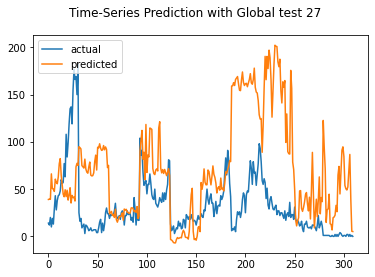

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 30.390
Test RMSE: 41.510
Test sMAPE: 108.138
Test R Squared: -0.737
{'mae': 30.389841396001078, 'rmse': 41.51004760937282, 'smape': 108.13755874902931, 'r2': -0.7367663557146888}


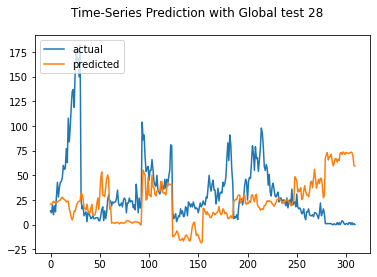

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 43.873
Test RMSE: 50.912
Test sMAPE: 97.574
Test R Squared: -1.613
{'mae': 43.87299759157242, 'rmse': 50.912410186046756, 'smape': 97.57379249753365, 'r2': -1.6126561027274784}


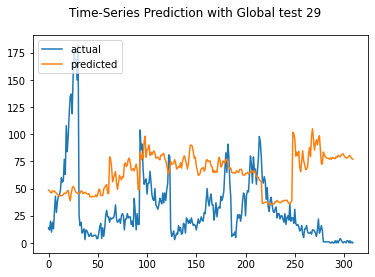

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 38.036
Test RMSE: 51.689
Test sMAPE: 100.819
Test R Squared: -1.693
{'mae': 38.03626978435824, 'rmse': 51.689139958371634, 'smape': 100.81936137899302, 'r2': -1.6929825962016851}


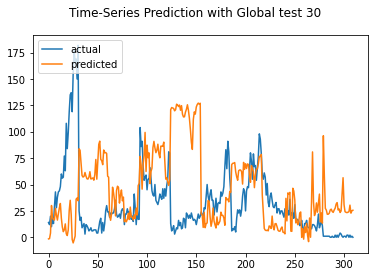

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.907
Test RMSE: 42.885
Test sMAPE: 108.053
Test R Squared: -0.854
{'mae': 31.906583384160072, 'rmse': 42.88501694667602, 'smape': 108.05307385588328, 'r2': -0.8537284126784181}


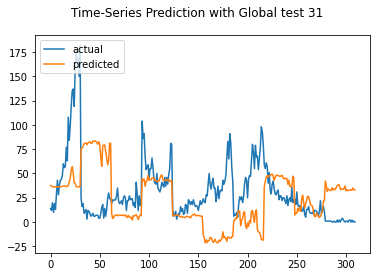

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 52.328
Test RMSE: 59.548
Test sMAPE: 110.963
Test R Squared: -2.574
{'mae': 52.328242564970445, 'rmse': 59.54816001109852, 'smape': 110.9627931836295, 'r2': -2.5741405590455995}


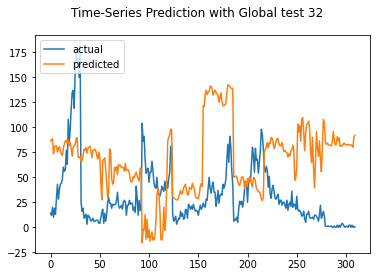

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 58.494
Test RMSE: 72.614
Test sMAPE: 119.814
Test R Squared: -4.315
{'mae': 58.49401350944273, 'rmse': 72.61424768445762, 'smape': 119.81389215574022, 'r2': -4.314698337252902}


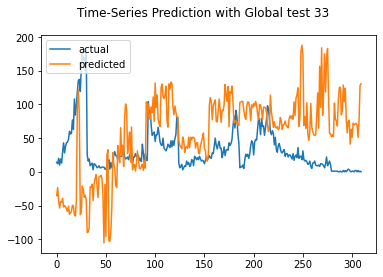

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 54.220
Test RMSE: 63.907
Test sMAPE: 129.173
Test R Squared: -3.117
{'mae': 54.22022373907028, 'rmse': 63.907247931569394, 'smape': 129.17316093773988, 'r2': -3.1165667884223778}


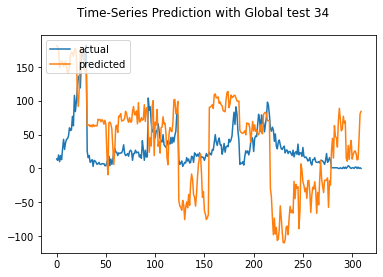

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 32.942
Test RMSE: 44.347
Test sMAPE: 99.753
Test R Squared: -0.982
{'mae': 32.941965081807105, 'rmse': 44.34687953482206, 'smape': 99.75252044844565, 'r2': -0.9822620509198106}


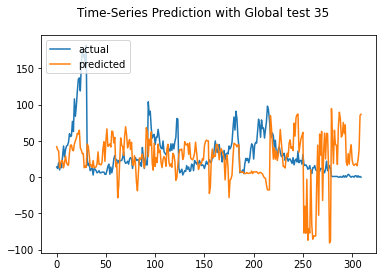

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 33.574
Test RMSE: 46.840
Test sMAPE: 88.021
Test R Squared: -1.211
{'mae': 33.57440615853956, 'rmse': 46.84019015581616, 'smape': 88.02112697432312, 'r2': -1.21142509436388}


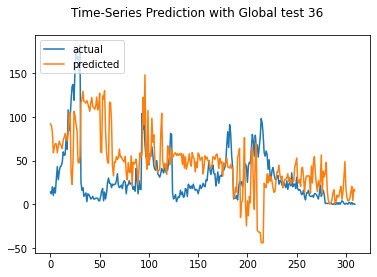

Test MAE: 37.549
Test RMSE: 46.323
Test sMAPE: 104.039
Test R Squared: -1.163
{'mae': 37.548870818845685, 'rmse': 46.323319259491, 'smape': 104.03888694610721, 'r2': -1.16288922051725}


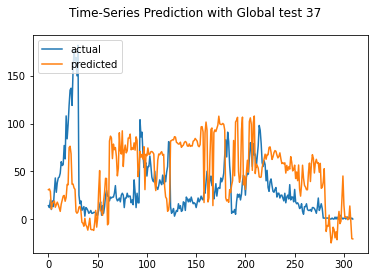

Test MAE: 39.530
Test RMSE: 46.722
Test sMAPE: 92.316
Test R Squared: -1.200
{'mae': 39.529742388571464, 'rmse': 46.72192093017056, 'smape': 92.31629017385788, 'r2': -1.2002717091962296}


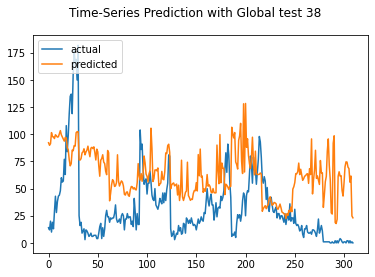

Test MAE: 40.076
Test RMSE: 46.750
Test sMAPE: 117.106
Test R Squared: -1.203
{'mae': 40.076430595690205, 'rmse': 46.750283989547704, 'smape': 117.10557483614562, 'r2': -1.2029439186495337}


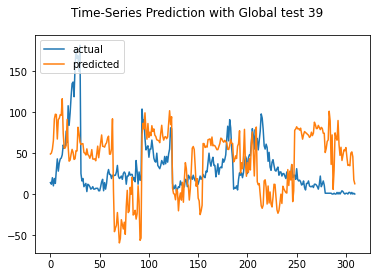

Test MAE: 55.199
Test RMSE: 65.977
Test sMAPE: 112.974
Test R Squared: -3.388
{'mae': 55.19920050982506, 'rmse': 65.97719468583733, 'smape': 112.97359425407069, 'r2': -3.3875555271554747}


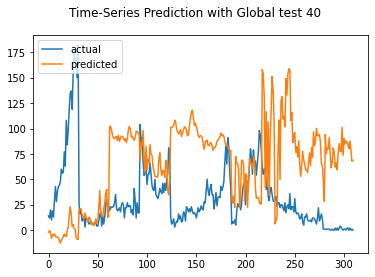

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 33.872
Test RMSE: 41.633
Test sMAPE: 100.611
Test R Squared: -0.747
{'mae': 33.872209500497384, 'rmse': 41.63259015201712, 'smape': 100.6112307317832, 'r2': -0.7470357687257823}


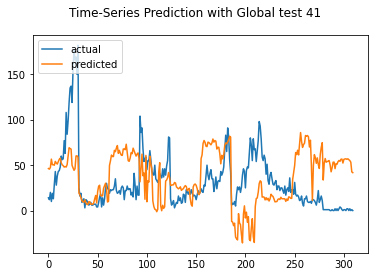

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 37.314
Test RMSE: 44.458
Test sMAPE: 106.752
Test R Squared: -0.992
{'mae': 37.31400911058149, 'rmse': 44.45773565680117, 'smape': 106.75213141316894, 'r2': -0.9921847575873408}


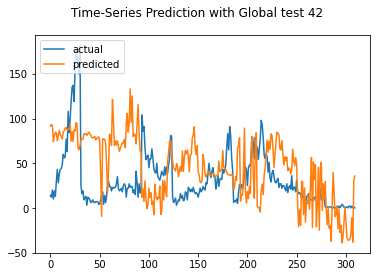

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 44.672
Test RMSE: 52.954
Test sMAPE: 102.309
Test R Squared: -1.826
{'mae': 44.672424983978274, 'rmse': 52.95382621242658, 'smape': 102.30902142799522, 'r2': -1.8263739788557314}


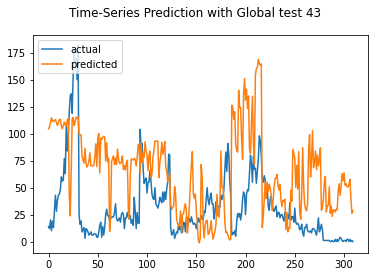

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 44.270
Test RMSE: 52.300
Test sMAPE: 94.976
Test R Squared: -1.757
{'mae': 44.27000006552665, 'rmse': 52.299957175826144, 'smape': 94.97626969599753, 'r2': -1.7570053001523962}


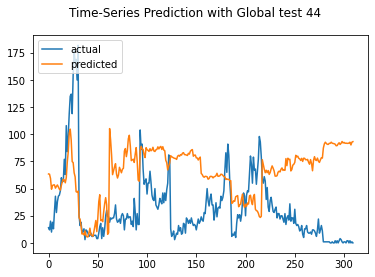

Test MAE: 38.748
Test RMSE: 46.241
Test sMAPE: 97.730
Test R Squared: -1.155
{'mae': 38.74803712906376, 'rmse': 46.240560991313174, 'smape': 97.72967014550039, 'r2': -1.1551679657900253}


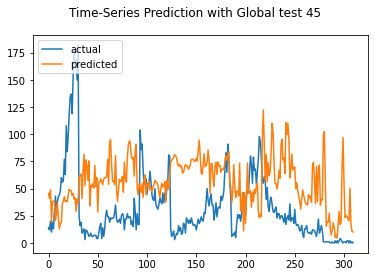

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 50.191
Test RMSE: 68.830
Test sMAPE: 103.949
Test R Squared: -3.775
{'mae': 50.19109260045713, 'rmse': 68.82988316546094, 'smape': 103.94869987199883, 'r2': -3.775171778851557}


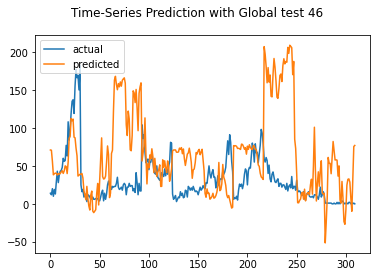

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 32.550
Test RMSE: 44.010
Test sMAPE: 104.980
Test R Squared: -0.952
{'mae': 32.55040188104876, 'rmse': 44.010451761129964, 'smape': 104.98001226965486, 'r2': -0.9523001498078882}


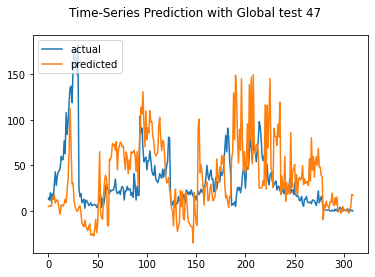

Test MAE: 60.909
Test RMSE: 71.582
Test sMAPE: 107.913
Test R Squared: -4.165
{'mae': 60.90948436490951, 'rmse': 71.58151314681471, 'smape': 107.91326160175382, 'r2': -4.164599914488135}


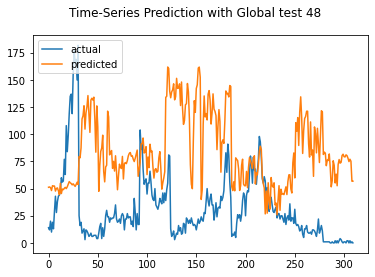

Test MAE: 42.258
Test RMSE: 52.079
Test sMAPE: 100.912
Test R Squared: -1.734
{'mae': 42.258069631072786, 'rmse': 52.07935551105914, 'smape': 100.91206840028885, 'r2': -1.7337962080056704}


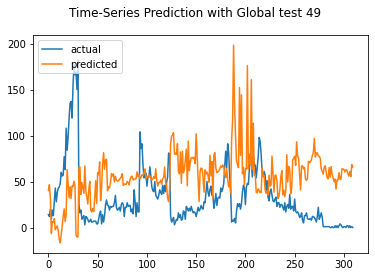

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 62.312
Test RMSE: 75.844
Test sMAPE: 129.092
Test R Squared: -4.798
{'mae': 62.311655848737686, 'rmse': 75.84373629228713, 'smape': 129.0917590845667, 'r2': -4.797948768233989}


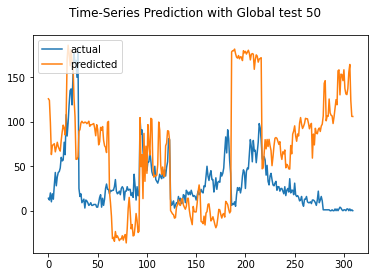

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 39.851
Test RMSE: 53.182
Test sMAPE: 132.115
Test R Squared: -1.851
{'mae': 39.85122122803042, 'rmse': 53.182091501178064, 'smape': 132.1150738849199, 'r2': -1.850793502580573}


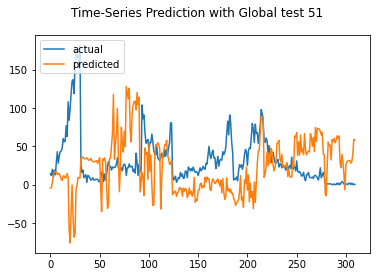

Test MAE: 68.962
Test RMSE: 79.214
Test sMAPE: 122.903
Test R Squared: -5.325
{'mae': 68.96204680319755, 'rmse': 79.21353700147142, 'smape': 122.90308486715266, 'r2': -5.324609931928167}


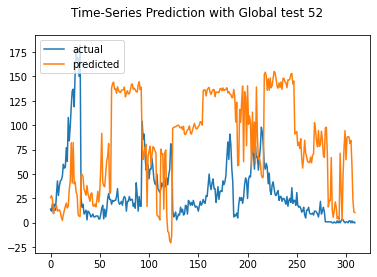

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 21.086
Test RMSE: 32.499
Test sMAPE: 81.761
Test R Squared: -0.065
{'mae': 21.08610549751789, 'rmse': 32.49914769090116, 'smape': 81.76091694078474, 'r2': -0.06458140841965698}


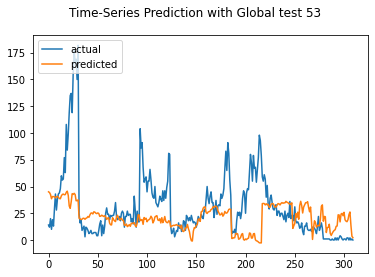

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 38.297
Test RMSE: 46.760
Test sMAPE: 92.455
Test R Squared: -1.204
{'mae': 38.297468283868604, 'rmse': 46.75983159868133, 'smape': 92.45490825585777, 'r2': -1.2038438060259264}


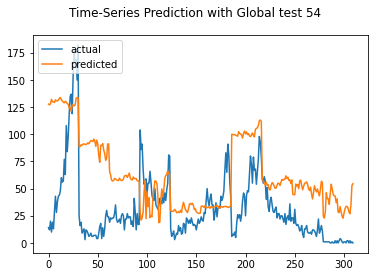

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 44.318
Test RMSE: 53.142
Test sMAPE: 103.246
Test R Squared: -1.847
{'mae': 44.31759897624293, 'rmse': 53.14221187145981, 'smape': 103.24627599365222, 'r2': -1.8465196592519648}


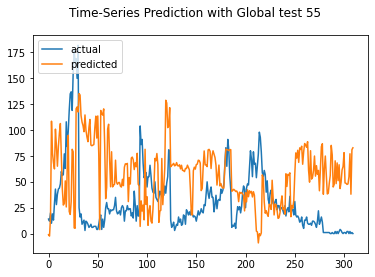

Test MAE: 59.033
Test RMSE: 71.848
Test sMAPE: 131.647
Test R Squared: -4.203
{'mae': 59.032591198913515, 'rmse': 71.84839886658459, 'smape': 131.64723898627486, 'r2': -4.203183270757829}


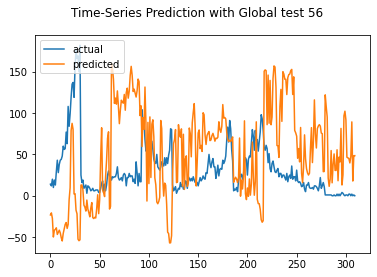

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 34.149
Test RMSE: 41.609
Test sMAPE: 119.112
Test R Squared: -0.745
{'mae': 34.14901105646164, 'rmse': 41.60930692083044, 'smape': 119.11206255506066, 'r2': -0.7450822384149791}


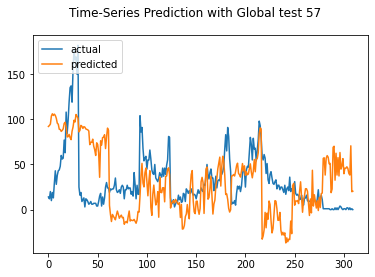

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 37.516
Test RMSE: 45.885
Test sMAPE: 130.177
Test R Squared: -1.122
{'mae': 37.51611125815299, 'rmse': 45.885488121063396, 'smape': 130.17684941237522, 'r2': -1.1221967568247968}


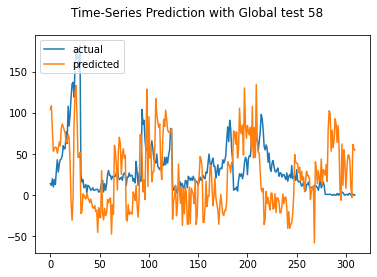

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 38.885
Test RMSE: 49.882
Test sMAPE: 109.475
Test R Squared: -1.508
{'mae': 38.88465383052826, 'rmse': 49.88202446167561, 'smape': 109.47504397700074, 'r2': -1.5079742692001137}


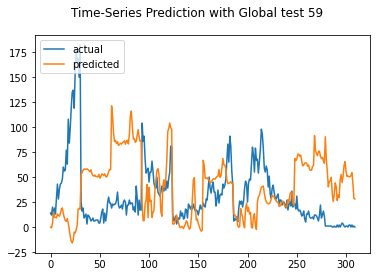

Test MAE: 51.792
Test RMSE: 62.820
Test sMAPE: 110.542
Test R Squared: -2.978
{'mae': 51.79174576344029, 'rmse': 62.819643050994614, 'smape': 110.54215665474518, 'r2': -2.9776435614818797}


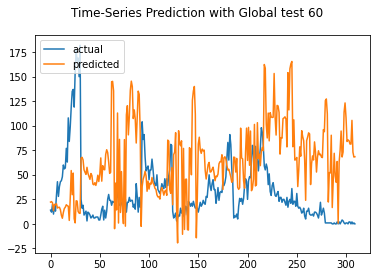

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 57.014
Test RMSE: 73.670
Test sMAPE: 128.093
Test R Squared: -4.470
{'mae': 57.01399427498541, 'rmse': 73.6704767992375, 'smape': 128.092679076779, 'r2': -4.470435424257389}


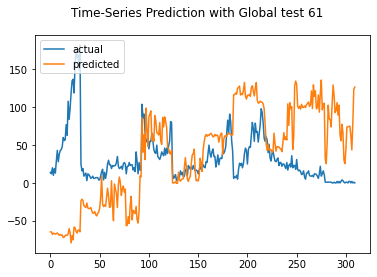

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 41.892
Test RMSE: 48.932
Test sMAPE: 101.889
Test R Squared: -1.413
{'mae': 41.89213022839638, 'rmse': 48.93173513802313, 'smape': 101.88868437691967, 'r2': -1.4133269738783851}


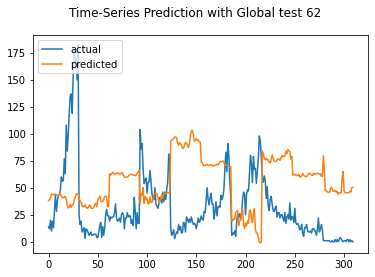

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 39.897
Test RMSE: 54.640
Test sMAPE: 127.066
Test R Squared: -2.009
{'mae': 39.89710269781851, 'rmse': 54.63961589234524, 'smape': 127.06564760107806, 'r2': -2.009194156631061}


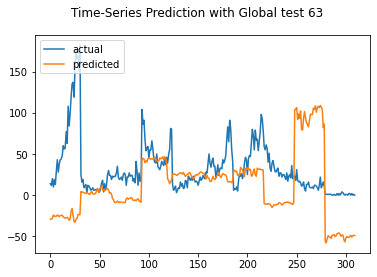

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.162
Test RMSE: 45.205
Test sMAPE: 108.864
Test R Squared: -1.060
{'mae': 37.162202593011244, 'rmse': 45.205318344710385, 'smape': 108.86378221996141, 'r2': -1.0597475665627982}


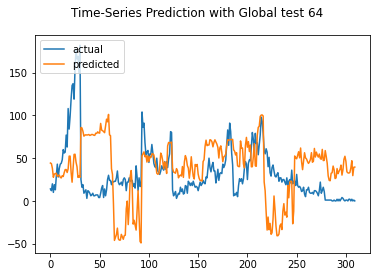

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 48.041
Test RMSE: 58.872
Test sMAPE: 150.872
Test R Squared: -2.493
{'mae': 48.04071494888875, 'rmse': 58.87165782618881, 'smape': 150.87225295868387, 'r2': -2.4933931628661847}


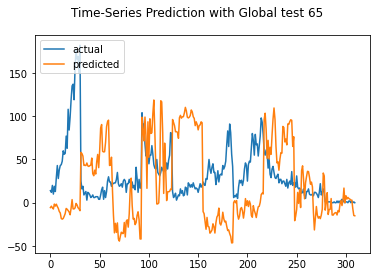

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 40.361
Test RMSE: 49.015
Test sMAPE: 107.647
Test R Squared: -1.422
{'mae': 40.36056847918418, 'rmse': 49.014531198915144, 'smape': 107.64720544905116, 'r2': -1.4215009336373265}


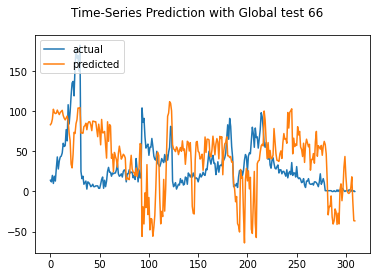

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 61.798
Test RMSE: 70.475
Test sMAPE: 115.176
Test R Squared: -4.006
{'mae': 61.79792873551769, 'rmse': 70.47504103637434, 'smape': 115.1761709419128, 'r2': -4.0061701844907605}


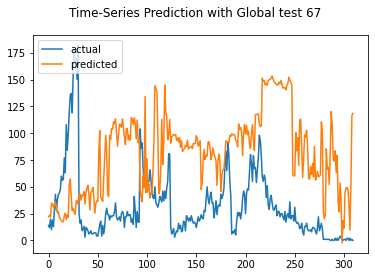

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.098
Test RMSE: 40.430
Test sMAPE: 81.503
Test R Squared: -0.648
{'mae': 31.0975558757782, 'rmse': 40.429623561134235, 'smape': 81.50330114558665, 'r2': -0.6475337873322708}


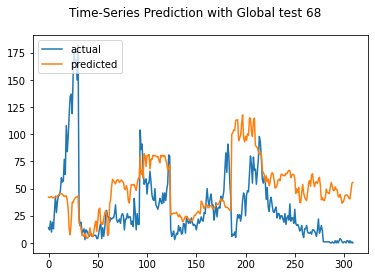

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 40.518
Test RMSE: 46.923
Test sMAPE: 113.593
Test R Squared: -1.219
{'mae': 40.51778263295851, 'rmse': 46.92340846317099, 'smape': 113.59277652883841, 'r2': -1.219289901545313}


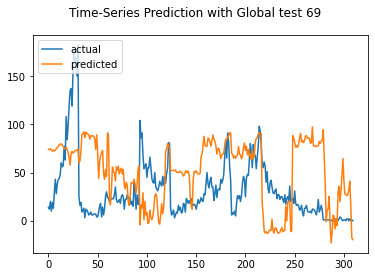

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 50.250
Test RMSE: 60.178
Test sMAPE: 100.352
Test R Squared: -2.650
{'mae': 50.25005606912797, 'rmse': 60.17756595074341, 'smape': 100.35171605110035, 'r2': -2.6500950138181576}


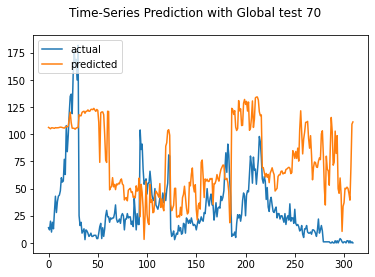

Test MAE: 59.660
Test RMSE: 70.215
Test sMAPE: 110.659
Test R Squared: -3.969
{'mae': 59.65988179752904, 'rmse': 70.21490527988632, 'smape': 110.65862377827082, 'r2': -3.969281085323927}


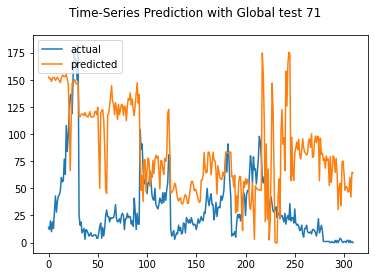

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 47.704
Test RMSE: 57.239
Test sMAPE: 114.232
Test R Squared: -2.302
{'mae': 47.70359880616588, 'rmse': 57.238928585499465, 'smape': 114.23225696536782, 'r2': -2.3023106589495903}


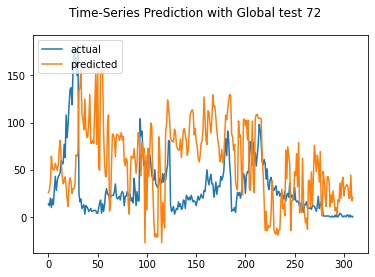

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 39.393
Test RMSE: 49.080
Test sMAPE: 94.326
Test R Squared: -1.428
{'mae': 39.392663679968926, 'rmse': 49.07950839922751, 'smape': 94.32550620963715, 'r2': -1.4279254220312376}


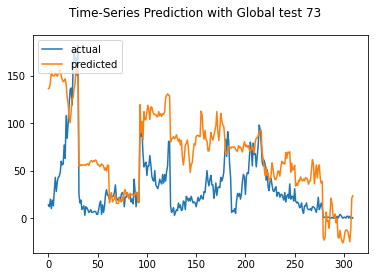

Test MAE: 41.340
Test RMSE: 54.747
Test sMAPE: 123.089
Test R Squared: -2.021
{'mae': 41.34022796077113, 'rmse': 54.74718852702711, 'smape': 123.08949218534896, 'r2': -2.0210546205112685}


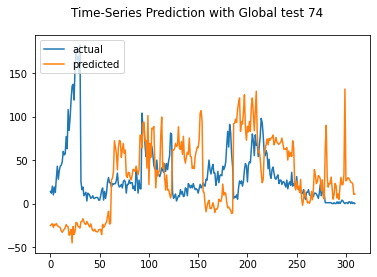

Test MAE: 43.940
Test RMSE: 51.435
Test sMAPE: 99.257
Test R Squared: -1.667
{'mae': 43.94006924167756, 'rmse': 51.435376010265834, 'smape': 99.25749734373547, 'r2': -1.666605512337985}


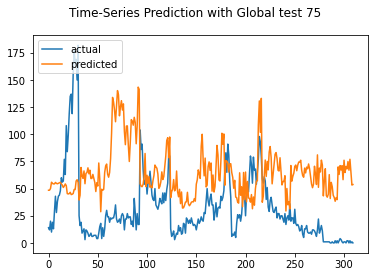

Test MAE: 58.204
Test RMSE: 68.832
Test sMAPE: 112.081
Test R Squared: -3.775
{'mae': 58.20368872304117, 'rmse': 68.83166777282625, 'smape': 112.08106128264032, 'r2': -3.775419401448344}


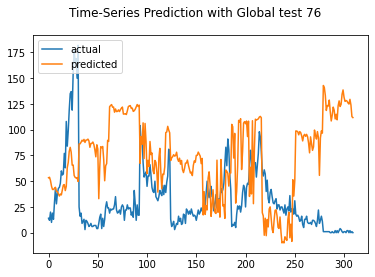

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 45.690
Test RMSE: 58.990
Test sMAPE: 118.000
Test R Squared: -2.507
{'mae': 45.69030370068165, 'rmse': 58.98953862857078, 'smape': 118.00033446942187, 'r2': -2.507397058429529}


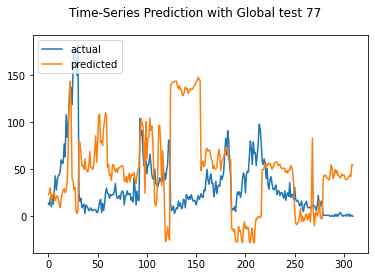

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 56.361
Test RMSE: 62.432
Test sMAPE: 129.992
Test R Squared: -2.929
{'mae': 56.36065269026064, 'rmse': 62.43190689098795, 'smape': 129.99159957177451, 'r2': -2.928693375275585}


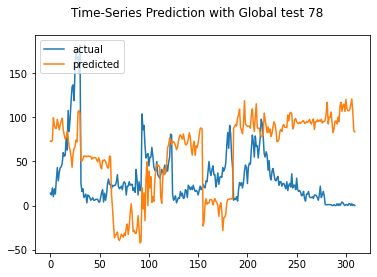

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 33.543
Test RMSE: 42.022
Test sMAPE: 109.986
Test R Squared: -0.780
{'mae': 33.54260420914619, 'rmse': 42.021978858214275, 'smape': 109.98574769425811, 'r2': -0.7798685710299975}


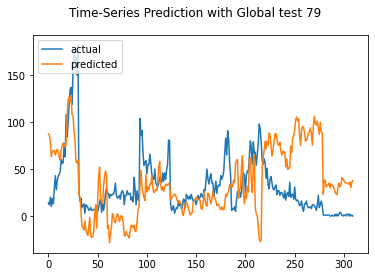

Test MAE: 53.109
Test RMSE: 69.319
Test sMAPE: 104.726
Test R Squared: -3.843
{'mae': 53.10862645295359, 'rmse': 69.31903142683275, 'smape': 104.72638566758235, 'r2': -3.84328366796525}


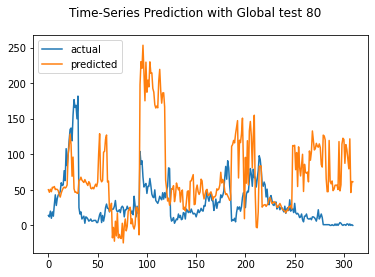

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 38.841
Test RMSE: 46.150
Test sMAPE: 99.681
Test R Squared: -1.147
{'mae': 38.84062693955437, 'rmse': 46.15042655872317, 'smape': 99.68057633930796, 'r2': -1.1467742304240591}


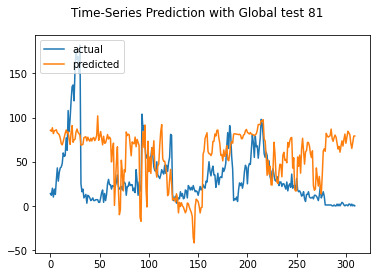

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.350
Test RMSE: 34.611
Test sMAPE: 79.084
Test R Squared: -0.207
{'mae': 25.35007337754773, 'rmse': 34.61106643704362, 'smape': 79.08400383682972, 'r2': -0.20743815792362685}


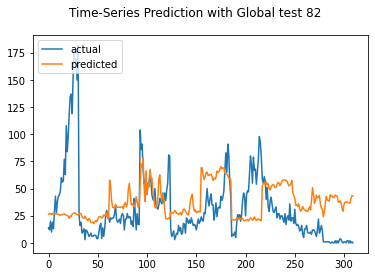

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 43.370
Test RMSE: 57.274
Test sMAPE: 118.658
Test R Squared: -2.306
{'mae': 43.369787107936794, 'rmse': 57.27430766301612, 'smape': 118.65817064122248, 'r2': -2.3063942018988395}


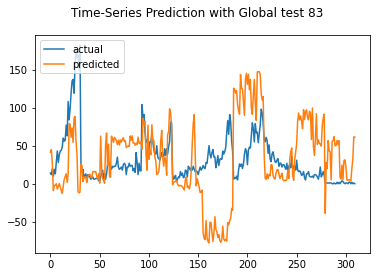

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 39.870
Test RMSE: 52.039
Test sMAPE: 105.431
Test R Squared: -1.730
{'mae': 39.86999143352432, 'rmse': 52.03943628909316, 'smape': 105.43104194217719, 'r2': -1.7296068630458774}


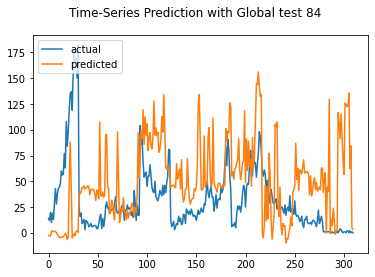

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 34.766
Test RMSE: 46.611
Test sMAPE: 120.877
Test R Squared: -1.190
{'mae': 34.76604089717711, 'rmse': 46.6112573805844, 'smape': 120.87738306114348, 'r2': -1.1898611133696217}


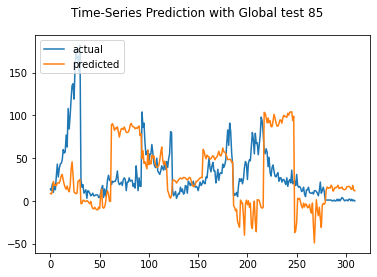

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 33.235
Test RMSE: 41.363
Test sMAPE: 127.317
Test R Squared: -0.724
{'mae': 33.23494552258522, 'rmse': 41.36310302758933, 'smape': 127.31671897589709, 'r2': -0.7244918966560734}


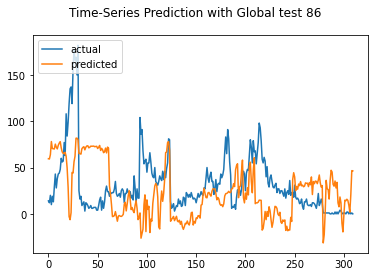

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 39.331
Test RMSE: 49.278
Test sMAPE: 111.810
Test R Squared: -1.448
{'mae': 39.33051451829172, 'rmse': 49.278251932479506, 'smape': 111.81034044023902, 'r2': -1.4476286132387366}


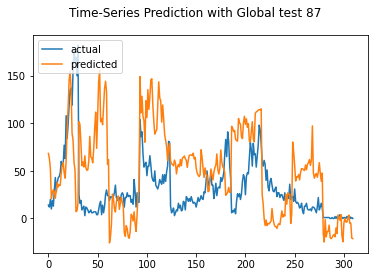

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 40.316
Test RMSE: 50.005
Test sMAPE: 116.341
Test R Squared: -1.520
{'mae': 40.315880376869636, 'rmse': 50.00452717217297, 'smape': 116.34054052957504, 'r2': -1.5203078065353108}


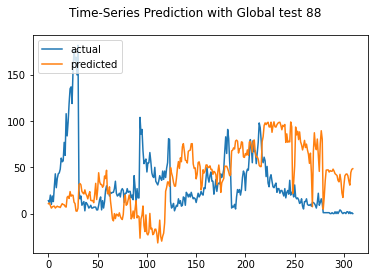

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 36.802
Test RMSE: 47.757
Test sMAPE: 126.717
Test R Squared: -1.299
{'mae': 36.80174047793111, 'rmse': 47.75748963353002, 'smape': 126.71743643165325, 'r2': -1.2988885365374476}


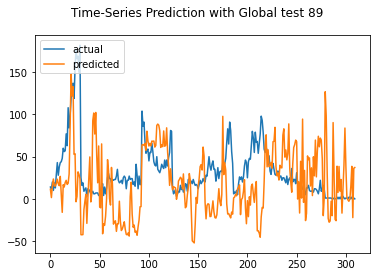

Test MAE: 52.125
Test RMSE: 58.169
Test sMAPE: 108.798
Test R Squared: -2.411
{'mae': 52.12515180726205, 'rmse': 58.16921951802885, 'smape': 108.79784661417533, 'r2': -2.4105263394043694}


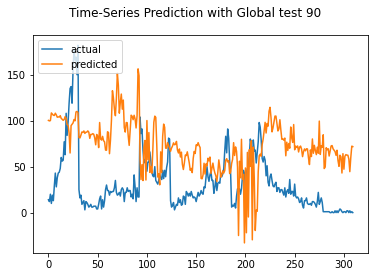

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 52.332
Test RMSE: 60.736
Test sMAPE: 107.769
Test R Squared: -2.718
{'mae': 52.33174082848333, 'rmse': 60.73588442509366, 'smape': 107.76862228902054, 'r2': -2.7181392819707075}


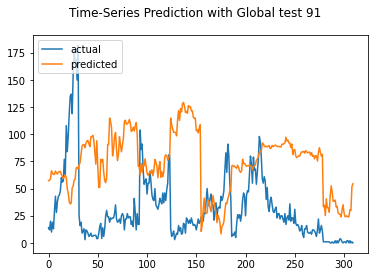

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 45.560
Test RMSE: 51.708
Test sMAPE: 101.698
Test R Squared: -1.695
{'mae': 45.56021754664759, 'rmse': 51.708141760930005, 'smape': 101.69792919883909, 'r2': -1.6949629320860273}


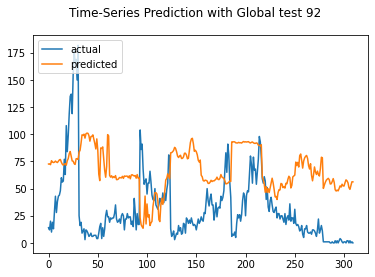

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 47.741
Test RMSE: 58.128
Test sMAPE: 105.707
Test R Squared: -2.406
{'mae': 47.74055002197142, 'rmse': 58.128275557713074, 'smape': 105.70672489246395, 'r2': -2.405726848834639}


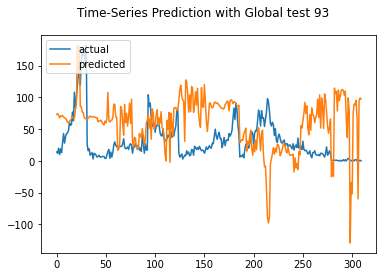

Test MAE: 39.759
Test RMSE: 49.995
Test sMAPE: 89.819
Test R Squared: -1.519
{'mae': 39.75905224161763, 'rmse': 49.99520811707271, 'smape': 89.81916609063293, 'r2': -1.5193685036325935}


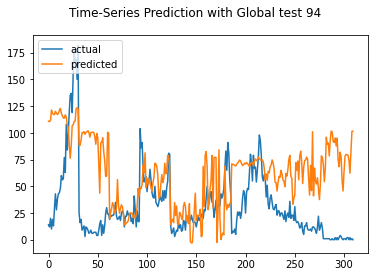

Test MAE: 57.125
Test RMSE: 64.667
Test sMAPE: 117.542
Test R Squared: -3.215
{'mae': 57.12472282994178, 'rmse': 64.6669386757464, 'smape': 117.5423225251065, 'r2': -3.215019017869955}


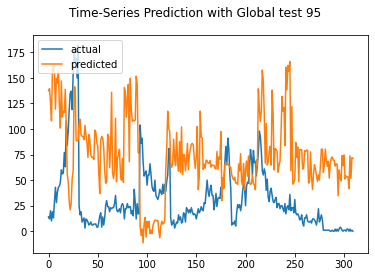

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 43.945
Test RMSE: 52.319
Test sMAPE: 101.659
Test R Squared: -1.759
{'mae': 43.944564354035165, 'rmse': 52.31883471513221, 'smape': 101.65870235094307, 'r2': -1.7589959277388822}


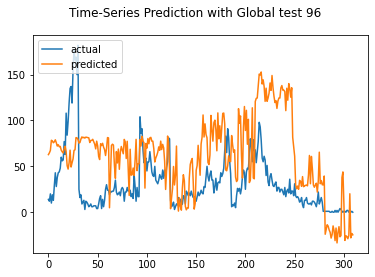

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 32.122
Test RMSE: 44.394
Test sMAPE: 93.405
Test R Squared: -0.986
{'mae': 32.12162458819728, 'rmse': 44.39367710462005, 'smape': 93.40486820696763, 'r2': -0.9864478693298746}


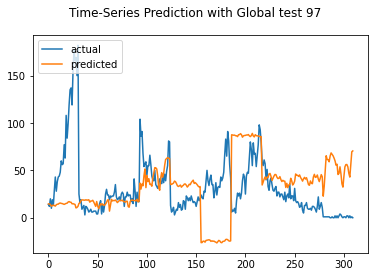

Test MAE: 53.001
Test RMSE: 64.581
Test sMAPE: 107.555
Test R Squared: -3.204
{'mae': 53.0014942475865, 'rmse': 64.58148726483758, 'smape': 107.55452582673972, 'r2': -3.203886857989363}


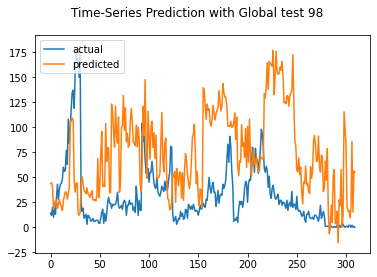

Test MAE: 41.813
Test RMSE: 49.861
Test sMAPE: 94.125
Test R Squared: -1.506
{'mae': 41.812906748248686, 'rmse': 49.860870307658764, 'smape': 94.12513529256253, 'r2': -1.5058475381843164}


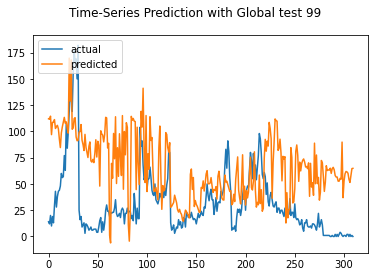

rmse : average=54.423, std=10.692
mae : average=44.397, std=10.119
smape : average=109.884, std=14.131
r2 : average=-2.101, std=1.240


([54.42254217285942, 10.692487827841097],
 [44.39654890562256, 10.11904451043469],
 [109.88364919481344, 14.13110972802372],
 [-2.10056877657177, 1.240358200718448])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')